In [96]:
import os
import sys
from matplotlib import pyplot as plt
sys.path.append('Lab02_NMT')

import numpy as np
import pandas as pd
import scipy as sp
from tqdm import tqdm
import yaml
import json
import librosa
from librosa import display as ld
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader

from neural_network import NN_CATALOG
from dataset.bird_clef import load_wav
from dataset.augmentations import Normalize
from experiment.base import get_fold

In [4]:
bird_tax = pd.read_csv('data/eBird_Taxonomy_v2021.csv', index_col=0)
all_meta = pd.read_csv('data/train_metadata_extended.csv')
with open('data/scored_birds.json') as fin:
    scored_birds = json.load(fin)

In [5]:
all_meta.loc[:, 'secondary_labels'] = all_meta.secondary_labels.apply(eval)
all_meta['target_raw'] = all_meta.secondary_labels + all_meta.primary_label.apply(lambda x: [x])

In [6]:
all_species = sorted(set(all_meta.target_raw.sum()))
species2id = {s: i for i, s in enumerate(all_species)}
id2species = {i: s for i, s in enumerate(all_species)}

all_meta['target'] = all_meta.target_raw.apply(lambda species: [int(s in species) for s in all_species])

In [57]:
teacher_target = None

### Dataset

In [46]:
class TestDataset(Dataset):
    def __init__(self, data_root, meta_pd, augmentations=None, split_size=30):
        super().__init__()
        self.data_root = data_root
        self.meta_pd = meta_pd
        self.fnames = meta_pd.filename.values
        self.augmentations = augmentations
        self.split_size = split_size
        
    def __len__(self):
        return len(self.fnames)
    
    def pad(self, wav, sr):
        padded = wav
        if len(wav) % int(sr * self.split_size) != 0:
            crop_size = int(sr * self.split_size)
            padded_shape = (len(wav) // crop_size  + 1) * crop_size 
            padded = np.zeros(padded_shape)
            padded[:len(wav)] = wav
        return padded
    
    
    def __getitem__(self, idx):
        fpath = os.path.join(self.data_root, self.fnames[idx])
        wav, sr = load_wav(fpath, 0, 300)
        if self.augmentations:
            wav = self.augmentations(wav, None)
        wav = self.pad(wav, sr)
        wav = torch.tensor(wav).float()
        
        wav_len = wav.shape[0]
        split_factor =  wav_len // (self.split_size * sr)
        wav = wav.reshape((split_factor, wav_len // split_factor))
        return wav
    

Алгоритм:

разметить по времени где и какая птица поет

далее использовать эту разметку для обучения

In [84]:
fold = 4
_, val_meta = get_fold(all_meta, fold, 5, 42)

In [85]:
test_dataset = TestDataset(
    'data/train_audio',
    val_meta, 
    augmentations=Normalize(p=1)
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    drop_last=False,   
)

### Model

In [86]:
config_path = 'Lab02_NMT/configs/baseline_config.yaml'
model_path = f'Lab02_NMT/model_save/baseline_39wbtt2e/{fold}_fold/final-model.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open(config_path) as fin:
    config = yaml.safe_load(fin)

model_config = config['model']
if 'backbone_config' in model_config['params']:
    model_config['params']['backbone_config']['pretrained'] = False
data_config = config['data']
model_class = NN_CATALOG[model_config['name']]

model = model_class(len(all_species), int(data_config['crop_len'] // data_config['test_wav_len']),
                    **model_config['params'])
model.to(device)

state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()

EffNet(
  (audio2image): Sequential(
    (0): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
    (1): AmplitudeToDB()
  )
  (backbone): Sequential(
    (0): Conv2dSame(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
    (3): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride

In [1]:
2**(-0.0)

0.9930924954370359

In [87]:
pred_list = []
treshold = 0.1
split_size = test_dataset.split_size

model.eval()
with torch.no_grad():
    for i, batch in tqdm(enumerate(test_dataloader), total = len(test_dataloader)):
        batch = batch[0]
        pred = model(batch.to(device))['logits']
        pred = pred.cpu().numpy()
        
        for j, chunk_pred in enumerate(pred):
            left_sec = j * split_size
            right_sec = (j + 1) * split_size
            fname = test_dataset.fnames[i]
            
            pred_list.append({
                'filename': fname,
                'right': right_sec,
                'left': left_sec,
                'pred': chunk_pred
            })
pred_pd = pd.DataFrame(pred_list)

100%|██████████| 2970/2970 [01:22<00:00, 35.85it/s]


In [88]:
if teacher_target is None:
    teacher_target = pred_pd.copy()
else:
    teacher_target = teacher_target.append(pred_pd)

In [92]:
teacher_target.to_csv('data/teacher_target.csv', index=False)

In [160]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import balanced_accuracy_score, brier_score_loss
from sklearn.model_selection import train_test_split

check calibration

In [163]:
idx = 0
brier_score_list = []
for idx, _ in enumerate(all_species):
    def pred_mean(x_series):
        return np.max([x[idx] for x in x_series])

    oof_pred = teacher_target.groupby('filename').agg(pred=('pred', pred_mean))\
                .merge(all_meta.filename, on='filename')\
                .pred.values
    target = [t[idx] for t in all_meta.target]
    brier_score_list.append(brier_score_loss(target, oof_pred))

(array([83., 22., 24., 10.,  6.,  4.,  1.,  0.,  1.,  1.]),
 array([0.0001267 , 0.00188441, 0.00364212, 0.00539983, 0.00715754,
        0.00891525, 0.01067296, 0.01243066, 0.01418837, 0.01594608,
        0.01770379]),
 <BarContainer object of 10 artists>)

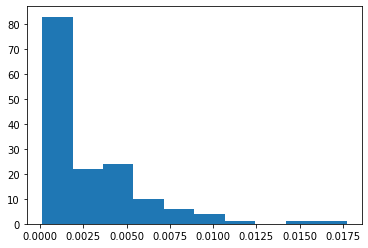

In [164]:
plt.hist(brier_score_list)

find tresholds

In [175]:
bird_trsh = []
for idx, _ in tqdm(enumerate(all_species), total=len(all_species)):
    def pred_mean(x_series):
        return np.max([x[idx] for x in x_series])

    oof_pred = teacher_target.groupby('filename').agg(pred=('pred', pred_mean))\
                .merge(all_meta.filename, on='filename')\
                .pred.values
    target = [t[idx] for t in all_meta.target]
    
    trsh = [*[i * 0.01 for i in range(1, 10)], *[i * 0.1 for i in range(1, 5)]]
    best_score = 0
    best_t = None
    for t in trsh:
        score = balanced_accuracy_score(target, oof_pred > t)
        if score > best_score:
            best_score = score
            best_t = t

    bird_trsh.append(best_t)

100%|██████████| 152/152 [01:23<00:00,  1.83it/s]


In [262]:
with open('data/teacher_trsh.json', 'w') as fout:
    json.dump(bird_trsh, fout)

filter teacher targets

In [191]:
teacher_target = teacher_target.merge(all_meta[['filename', 'target']], on='filename')

teacher_target['p_vs_t'] = teacher_target.apply(lambda x: list(zip(x.pred, x.target)), axis=1)

def find_topk(x_series, topk=4):
    pred = np.array([[p for p, _ in x] for x in x_series])
    gt = np.array([t for _, t in x_series.iloc[0]])
    if gt.sum() > 1:
        return gt
    else:
        max_pred = pred.max(axis=0)
        max_pred = np.array([(p + t) if (p + t) > trsh else 0 for p, t, trsh in zip(max_pred, gt, bird_trsh)])
        order = max_pred.argsort()
        ranks = order.argsort()
        is_topk = [int(r >= (len(ranks) - topk)) for r in ranks]
        return is_topk
        

topk_teacher = teacher_target.groupby('filename').agg(to_pred=('p_vs_t', find_topk))

topk_teacher.reset_index(inplace=True)

In [256]:
teacher_target = teacher_target.merge(topk_teacher, on='filename')

In [260]:
teacher_target['filt_pred'] = teacher_target.apply(
    lambda x: [p if (p > trsh and bool(tp)) or bool(t) else 0 
               for p, trsh, t, tp in zip(x.pred, bird_trsh, x.target, x.to_pred)],
    axis=1
)

In [263]:
teacher_target.to_csv('data/teacher_target_filt.csv', index=False)

In [264]:
teacher_target

,filename,right,left,pred,target,p_vs_t,to_pred,filt_pred
0,afrsil1/XC205893.ogg,30,0,"[0.017681198, 0.0029309653, 0.013209334, 0.019...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(0.017681198, 1), (0.0029309653, 0), (0.01320...","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.017681198, 0, 0, 0, 0, 0, 0, 0, 0.25694358,..."
1,afrsil1/XC205893.ogg,60,30,"[0.07278254, 0.008117468, 0.037961964, 0.03145...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(0.07278254, 1), (0.008117468, 0), (0.0379619...","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.07278254, 0, 0, 0, 0, 0, 0, 0, 0.120911, 0,..."
2,afrsil1/XC205893.ogg,90,60,"[0.07520704, 0.0059751794, 0.010243854, 0.0184...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(0.07520704, 1), (0.0059751794, 0), (0.010243...","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.07520704, 0, 0, 0, 0, 0, 0, 0, 0.23415431, ..."
3,afrsil1/XC205893.ogg,120,90,"[0.054545492, 0.00711697, 0.013146085, 0.01811...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(0.054545492, 1), (0.00711697, 0), (0.0131460...","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.054545492, 0, 0, 0, 0, 0, 0, 0, 0.23324755,..."
4,afrsil1/XC317039.ogg,30,0,"[0.11518001, 0.0067015393, 0.0057773422, 0.007...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(0.11518001, 1), (0.0067015393, 0), (0.005777...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.11518001, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...
28837,zebdov/XC560520.ogg,60,30,"[0.08116366, 0.0011684262, 0.0026881555, 0.000...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(0.08116366, 0), (0.0011684262, 0), (0.002688...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.08116366, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
28838,zebdov/XC560520.ogg,90,60,"[0.049092244, 0.0017492274, 0.002975369, 0.001...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(0.049092244, 0), (0.0017492274, 0), (0.00297...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
28839,zebdov/XC576417.ogg,30,0,"[0.036551293, 0.0005443285, 0.0033690694, 0.00...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(0.036551293, 0), (0.0005443285, 0), (0.00336...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
28840,zebdov/XC665873.ogg,30,0,"[0.0057868296, 0.001039923, 0.0021277363, 0.00...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(0.0057868296, 0), (0.001039923, 0), (0.00212...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
